In [30]:
import numpy as np
import matplotlib.pyplot as plt

from utils_for_examples import *
from gaussian_drift_utils import *
np.random.seed(1)


In [27]:
dim = 3
A = np.eye(dim)
B_ = np.random.randn(dim,dim)
B = B_@B_.T


Ntest = 10000
Nsamples = [1000, 2500, 3000, 5000, 7500]
tauz = [0.2, 0.5, 0.8, 0.9]
ntrials = 10
mse_comparison = np.zeros((len(Nsamples),len(tauz),ntrials))

eps = 1.
Ceps = Cepsilon(A,B,eps)

for i in range(len(Nsamples)):
    for j in range(len(tauz)):
        τ = tauz[j]
        Sigma_tau = Sigma_t(A,B,eps,Ceps,τ)
        drift_tau = drift_t(A,B,eps,τ)
        for k in range(ntrials):
            n = Nsamples[i]
            ## generate new samples for MCMC
            gen_Xtau = gen_gaussian_samples(np.zeros(dim),Sigma_tau,Ntest)

            ## generate closed-form drift
            closed_form_drift = drift_tau@gen_Xtau.copy()

            ## estimate the drift based on samples at time τ
            xA = gen_gaussian_samples(np.zeros(dim),A,n)
            xB = gen_gaussian_samples(np.zeros(dim),B,n)
            _,geps_over_eps = sinkhorn_potentials(xA,xB,eps,dim,n,1000)
            drift_estimator = ent_drift(xB.T,geps_over_eps,eps)
            estimated_drift = drift_estimator(gen_Xtau.T,1-τ)

            mse_comparison[i,j,k] = np.mean(np.linalg.norm( estimated_drift.T - closed_form_drift,axis=0 )**2)

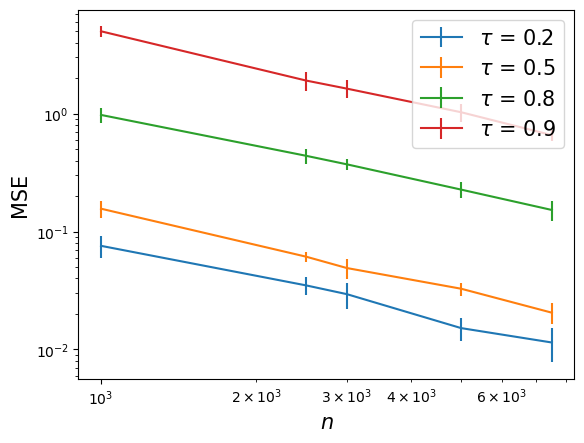

In [29]:
ax = plt.axes()
x = np.array(Nsamples)
for j in range(0,len(tauz)):
    tau = tauz[j]
    mse_j = mse_comparison[:,j,:]
    mse_j_means = np.mean(mse_j,axis=-1)
    mse_j_stds = np.std(mse_j,axis=-1)

    plt.errorbar(x,mse_j_means,yerr=mse_j_stds,linewidth=1.5,label=r'$\tau$ = {}'.format(tau))

    
ax.set_xscale("log")
ax.set_yscale("log")
plt.xlabel('$n$',fontsize=15)
plt.ylabel('MSE',fontsize=15)
ax.legend(loc='upper right',fontsize=15)
plt.savefig('gaussian_drifts_test.png',dpi=300,bbox_inches='tight',format='png')